In [1]:
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
tf.keras.backend.set_session(tf.Session(config=sess_config))

In [2]:
import os
import glob
#import tqdm
import numpy as np
#import pandas as pd
import multiprocessing
import pydicom as dicom
import nibabel as nib
#from keras import utils as kutils
from matplotlib import pyplot as plt

def load_image(label_fpath, transpose=False):
    #encode_name = label_fpath[-39: -7]
    label_data = nib.load(label_fpath)
    label_array = label_data.get_fdata()
    if transpose:
        label_array = np.transpose(label_array, axes=(2, 1, 0))
    return  label_array#, encode_name

In [3]:
import pandas as pd
info = pd.read_csv('/data2/pancreas/Nifti_data/data_list.csv')

info['total'] = [1]*len(info)
pd.DataFrame(info.groupby(['cut', 'type']).sum().total)

total
cut   type          
fine  healthy    102
      tumor       44
thick healthy     82
      tumor      197

In [6]:
cd ..

/home/u/wartytw


In [17]:
import pandas as pd
info = pd.read_csv('/data2/pancreas/Nifti_data/data_list.csv')
image_path = "/data2/pancreas/Nifti_data/image"
label_path = "/data2/pancreas/Nifti_data/label"


shape = np.load("Resection_stage1/shape.npz.npy")
resec = np.load("Resection_stage1/resec.npy")
y = np.load("Resection_stage1/resec_y.npy")
tumor_shape = np.load("Resection_stage1/shape_tumor.npy")

In [12]:
print(shape_tumor.shape)
print(shape.shape)

(182, 6)
(182, 6)


In [8]:
size = []

for name in resec:
    size.append(info.iloc[np.where(info.case_id == name)]['size'].values[0])
    

In [10]:
#New
def extract_cube(r, img):#cube 210, 220, 90 ;; ranges = [xmin, xmax, ymin, ymax, zmin, zmax]
    img_tmp = np.zeros((210, 220, 90))
    #print(img.shape, r)
    img_tmp[:int(r[1]-r[0]), :int(r[3]-r[2]), :int(r[5]-r[4])] = img[int(r[0]):int(r[1]), int(r[2]):int(r[3]), int(r[4]):int(r[5])]
    return img_tmp


def masking(label, img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if label[i, j] == 0 or label[i, j] == 1:
                img[i, j] = 0
    return img

import pandas as pd
map_df = pd.DataFrame(data={'resec_name': resec, 'shape': np.array(range(182)), 'target':y.reshape(182)})


In [11]:
from keras.models import Model#, load_model
from keras import layers as klayers
from keras.optimizers import Adam
from keras import utils as kutils
from keras import backend as K
from keras.callbacks import ModelCheckpoint



from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
#from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
#import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py

#init_notebook_mode(connected=True)
%matplotlib inline


from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate,  MaxPool2D
# from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv1D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Reshape
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline



Using TensorFlow backend.


In [46]:
from keras.utils import to_categorical

class resec_Generator1(kutils.Sequence):
    'Generates data for Keras'
    def __init__(self, mapping_df, batch_size, shuffle=True):
        'Initialization'
        self.mapping_df = mapping_df
        self.data_num   = mapping_df.shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.data_num / self.batch_size))


    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print("enter0")
        batch_mapping_df = \
            self.mapping_df.iloc[index*self.batch_size: (index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(batch_mapping_df)
        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            self.mapping_df = self.mapping_df.sample(frac=1).reset_index(drop=True)
            
    def __data_generation(self, batch_mapping_df):
        'Generates data containing batch_size samples' 
        # Initialization
        X = np.zeros((  self.batch_size, 210, 220, 90, 1)) 
#         x1 = np.zeros((self.batch_size, 1))
#         x2 = np.zeros((self.batch_size, 6))
        x3 = np.zeros((self.batch_size, 6))
        y = np.zeros((self.batch_size))

        # Generate data
        cnt = 0
        
        for i, row in batch_mapping_df.iterrows():
            #img = extract_cube(shape_tumor[row['shape']], load_image(os.path.join(image_path, "IM_"+row['resec_name']+".nii.gz")))
            encode = row['resec_name']
            volume_image = load_image(os.path.join(image_path, "IM_"+encode+".nii.gz"))
            label = load_image(os.path.join(label_path, "LB_"+encode+".nii.gz"))
            volume_image1 = extract_cube(shape_tumor[row['shape'], :], volume_image) 
            label1 = extract_cube(shape_tumor[row['shape'], :], label) 
            num_slice = volume_image1.shape[2]
            for _z in range(0, num_slice):
                label11 = ndimage.binary_dilation(label1[:, :, _z]).astype(label1[:, :, _z].dtype)
                volume_image1[..., _z] = masking(label11, volume_image1[..., _z])
                del label11

            #print(encode)
            X[ cnt, :, :, :, 0] = volume_image1
#             x1[cnt, :] = size[row['shape']]
#             x2[cnt, :] = shape[row['shape'], :]
            x3[cnt, :] = tumor_shape[row['shape'], :]
            del volume_image1, label1, volume_image, label
            #img = clip_img(load_image(os.path.join(image_path, "IM_"+row['resec_name']+".nii.gz")))
            #print("resec_name =", row['resec_name'])
#             for j in range(40):
#                 #print("img shape =", img.shape)
#                 #print("j =", j)
#                 X[j][cnt, :, :, :, 0] = extract_cube(img, j)
            y[cnt] = row['target']

#             position = extract_position(row['ref_idx'], row['point_idx'])
#             tmp_cube = extract_cube(position, row['ref_idx'])
#             if (tmp_cube.shape == (19, 19, 19)):
#                 X[cnt, :, :, :, 0] = extract_cube(position, row['ref_idx'])
#             else:
#                 X[cnt, :, :, :, 0] = np.zeros((19, 19, 19))
#             y_idx = row['y_idx']
#             radius = ref[row['ref_idx']][row['point_idx'], 3]
#             y1[cnt, y_idx] = 1
#             y2[cnt, 0] = radius
            cnt += 1
        #print(X[5])
        return [X, x3], y

# for name in resec:
#     img = load_image(os.path.join(image_path, "IM_"+name+".nii.gz"))

In [50]:
from keras import metrics
tmp_x = Input((210, 220, 90, 1))
x = Conv3D(filters=32, dilation_rate=1, kernel_size=(3, 3, 3),kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu')(tmp_x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = MaxPool3D()(x)

x = Conv3D(filters=16, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = MaxPool3D()(x)

x = Conv3D(filters=8, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool3D()(x)



x = Conv3D(filters=4, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool3D()(x)


x = Flatten()(x)
x = Dense(units=500, kernel_initializer = keras.initializers.he_normal(seed=None), activation='elu')(x)
x = Dense(units=100, activation='selu')(x)
x = Dense(units=10, activation='relu')(x)


# tmp_a = Input((1,))
# a = Dense(5, activation='elu')(tmp_a)
# a = Dense(2, activation='relu')(a)
# a = Dense(1,kernel_initializer = keras.initializers.he_normal(seed=None),  activation='relu')(a)

# tmp_b = Input((6,))
# b = Dense(10, activation='selu')(tmp_b)
# b = Dense(20, activation='selu')(b)
# b = Dense(10, activation='elu')(b)
# b = Dense(5,kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu' )(b)
# b = Dense(3, activation='relu')(b)


tmp_c = Input((6,))
c = Dense(10,kernel_initializer = keras.initializers.he_normal(seed=None),  activation='selu')(tmp_c)
c = Dense(20, activation='selu')(c)
c = Dense(10, activation='elu')(c)
c = Dense(5,activation='relu' )(c)
c = Dense(3, activation='relu')(c)

x = concatenate([x, c], axis = 1)
x = Dense(1, activation='sigmoid')(x)





model = Model(inputs=[tmp_x,  tmp_c], outputs=x)
adam_lr = 0.0002
adam_beta_1 = 0.5
model.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
              loss='binary_crossentropy', metrics = [metrics.binary_accuracy])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 210, 220, 90, 0                                            
__________________________________________________________________________________________________
conv3d_21 (Conv3D)              (None, 208, 218, 88, 896         input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 208, 218, 88, 128         conv3d_21[0][0]                  
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 208, 218, 88, 0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
max_poolin

In [51]:
batch_size = 2
v_generator = resec_Generator1(map_df[:-50], batch_size=batch_size)
validation_generator = resec_Generator1(map_df[-50:-30], batch_size=batch_size)

In [52]:
from scipy import ndimage
history = model.fit_generator(v_generator,
                              epochs=100, validation_data=validation_generator)

Epoch 1/100
66/66 [==============================] - 518s 8s/step - loss: 0.8048 - binary_accuracy: 0.4848 - val_loss: 0.7485 - val_binary_accuracy: 0.5000
Epoch 2/100
66/66 [==============================] - 507s 8s/step - loss: 0.7371 - binary_accuracy: 0.4394 - val_loss: 0.7185 - val_binary_accuracy: 0.4500
Epoch 3/100
66/66 [==============================] - 510s 8s/step - loss: 0.7060 - binary_accuracy: 0.4621 - val_loss: 0.7034 - val_binary_accuracy: 0.5000
Epoch 4/100
66/66 [==============================] - 512s 8s/step - loss: 0.6882 - binary_accuracy: 0.4697 - val_loss: 0.6911 - val_binary_accuracy: 0.6000
Epoch 5/100
66/66 [==============================] - 508s 8s/step - loss: 0.6798 - binary_accuracy: 0.5379 - val_loss: 0.6888 - val_binary_accuracy: 0.4500
Epoch 6/100
66/66 [==============================] - 506s 8s/step - loss: 0.6752 - binary_accuracy: 0.5758 - val_loss: 0.6850 - val_binary_accuracy: 0.4500
Epoch 7/100
66/66 [==============================] - 507s 8s/ste

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



66/66 [==============================] - 550s 8s/step - loss: 0.5352 - binary_accuracy: 0.7727 - val_loss: 0.5613 - val_binary_accuracy: 0.8000
Epoch 91/100
66/66 [==============================] - 520s 8s/step - loss: 0.5265 - binary_accuracy: 0.7652 - val_loss: 0.5855 - val_binary_accuracy: 0.7000
Epoch 92/100
66/66 [==============================] - 545s 8s/step - loss: 0.5293 - binary_accuracy: 0.7727 - val_loss: 0.5818 - val_binary_accuracy: 0.7500
Epoch 93/100
66/66 [==============================] - 526s 8s/step - loss: 0.5336 - binary_accuracy: 0.7727 - val_loss: 0.5730 - val_binary_accuracy: 0.8000
Epoch 94/100
66/66 [==============================] - 520s 8s/step - loss: 0.5233 - binary_accuracy: 0.7955 - val_loss: 0.5515 - val_binary_accuracy: 0.8000
Epoch 95/100
66/66 [==============================] - 512s 8s/step - loss: 0.5270 - binary_accuracy: 0.7727 - val_loss: 0.5586 - val_binary_accuracy: 0.8000
Epoch 96/100
66/66 [==============================] - 515s 8s/step - lo

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


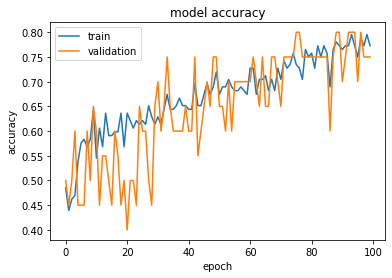

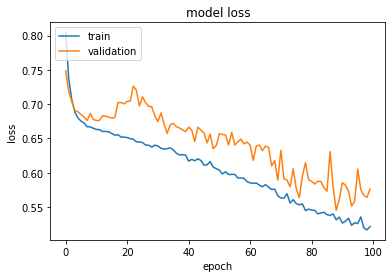

In [53]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
from keras.utils import to_categorical

class resec_Generator1(kutils.Sequence):
    'Generates data for Keras'
    def __init__(self, mapping_df, batch_size, shuffle=True):
        'Initialization'
        self.mapping_df = mapping_df
        self.data_num   = mapping_df.shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.data_num / self.batch_size))


    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print("enter0")
        batch_mapping_df = \
            self.mapping_df.iloc[index*self.batch_size: (index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(batch_mapping_df)
        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            self.mapping_df = self.mapping_df.sample(frac=1).reset_index(drop=True)
            
    def __data_generation(self, batch_mapping_df):
        'Generates data containing batch_size samples' 
        # Initialization
        
        x1 = np.zeros((self.batch_size, 1))
        x2 = np.zeros((self.batch_size, 6))
        x3 = np.zeros((self.batch_size, 6))
        y = np.zeros((self.batch_size))

        # Generate data
        cnt = 0
        
        for i, row in batch_mapping_df.iterrows():
            
            
            
            x1[cnt, :] = size[row['shape']]
            x2[cnt, :] = shape[row['shape'], :]
            x3[cnt, :] = tumor_shape[row['shape'], :]
 
            y[cnt] = row['target']

#             position = extract_position(row['ref_idx'], row['point_idx'])
#             tmp_cube = extract_cube(position, row['ref_idx'])
#             if (tmp_cube.shape == (19, 19, 19)):
#                 X[cnt, :, :, :, 0] = extract_cube(position, row['ref_idx'])
#             else:
#                 X[cnt, :, :, :, 0] = np.zeros((19, 19, 19))
#             y_idx = row['y_idx']
#             radius = ref[row['ref_idx']][row['point_idx'], 3]
#             y1[cnt, y_idx] = 1
#             y2[cnt, 0] = radius
            cnt += 1
        #print(X[5])
        return [ x1, x2, x3], y

# for name in resec:
#     img = load_image(os.path.join(image_path, "IM_"+name+".nii.gz"))

In [31]:
from keras import metrics




tmp_a = Input((1,))
a = Dense(5, activation='elu')(tmp_a)
a = Dense(2, activation='relu')(a)
a = Dense(1,kernel_initializer = keras.initializers.he_normal(seed=None),  activation='relu')(a)

tmp_b = Input((6,))
b = Dense(10, activation='selu')(tmp_b)
b = Dense(20, activation='selu')(b)
b = Dense(10, activation='elu')(b)
b = Dense(5,kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu' )(b)
b = Dense(3, activation='relu')(b)


tmp_c = Input((6,))
c = Dense(10, activation='selu')(tmp_c)
c = Dense(20, activation='selu')(c)
c = Dense(10, activation='elu')(c)
c = Dense(5,kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu' )(c)
c = Dense(3, activation='relu')(c)

a = concatenate([ a, b, c], axis = 1)
a = Dense(1, activation='sigmoid')(a)





model = Model(inputs=[ tmp_a, tmp_b, tmp_c], outputs=a)
adam_lr = 0.0002
adam_beta_1 = 0.5
model.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
              loss='binary_crossentropy', metrics = [metrics.binary_accuracy])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 6)            0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 6)            0                                            
__________________________________________________________________________________________________
dense_69 (Dense)                (None, 10)           70          input_17[0][0]                   
__________________________________________________________________________________________________
dense_74 (Dense)                (None, 10)           70          input_18[0][0]                   
__________________________________________________________________________________________________
input_16 (

In [32]:
batch_size = 2
v_generator = resec_Generator1(map_df[:-50], batch_size=batch_size)
validation_generator = resec_Generator1(map_df[-50:-30], batch_size=batch_size)

In [35]:
from scipy import ndimage
history = model.fit_generator(v_generator,
                              epochs=100, validation_data=validation_generator)

Epoch 1/100
66/66 [==============================] - 1s 13ms/step - loss: 0.3594 - binary_accuracy: 0.8561 - val_loss: 0.4816 - val_binary_accuracy: 0.8000
Epoch 2/100
66/66 [==============================] - 1s 13ms/step - loss: 0.3548 - binary_accuracy: 0.8561 - val_loss: 0.5054 - val_binary_accuracy: 0.8000
Epoch 3/100
66/66 [==============================] - 1s 14ms/step - loss: 0.3644 - binary_accuracy: 0.8409 - val_loss: 0.4820 - val_binary_accuracy: 0.7500
Epoch 4/100
66/66 [==============================] - 1s 13ms/step - loss: 0.3563 - binary_accuracy: 0.8485 - val_loss: 0.5198 - val_binary_accuracy: 0.7500
Epoch 5/100
66/66 [==============================] - 1s 13ms/step - loss: 0.3649 - binary_accuracy: 0.8485 - val_loss: 0.4867 - val_binary_accuracy: 0.8000
Epoch 6/100
66/66 [==============================] - 1s 13ms/step - loss: 0.3512 - binary_accuracy: 0.8712 - val_loss: 0.5324 - val_binary_accuracy: 0.7500
Epoch 7/100
66/66 [==============================] - 1s 14ms/ste

In [57]:
from scipy import ndimage
history = model.fit_generator(v_generator,
                              epochs=100, validation_data=validation_generator)

Epoch 1/100
66/66 [==============================] - 511s 8s/step - loss: 0.5168 - binary_accuracy: 0.7652 - val_loss: 0.5893 - val_binary_accuracy: 0.7500
Epoch 2/100
66/66 [==============================] - 508s 8s/step - loss: 0.5169 - binary_accuracy: 0.7879 - val_loss: 0.5583 - val_binary_accuracy: 0.7500
Epoch 3/100
66/66 [==============================] - 508s 8s/step - loss: 0.5120 - binary_accuracy: 0.7803 - val_loss: 0.5814 - val_binary_accuracy: 0.7500
Epoch 4/100
66/66 [==============================] - 519s 8s/step - loss: 0.5077 - binary_accuracy: 0.8106 - val_loss: 0.5617 - val_binary_accuracy: 0.7500
Epoch 5/100
66/66 [==============================] - 535s 8s/step - loss: 0.5096 - binary_accuracy: 0.7652 - val_loss: 0.5835 - val_binary_accuracy: 0.7000
Epoch 6/100
66/66 [==============================] - 522s 8s/step - loss: 0.4981 - binary_accuracy: 0.7727 - val_loss: 0.5534 - val_binary_accuracy: 0.7500
Epoch 7/100
66/66 [==============================] - 515s 8s/ste

In [ ]:
from scipy import ndimage
history = model.fit_generator(v_generator,
                              epochs=2, validation_data=validation_generator)

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


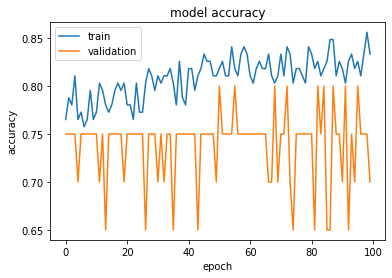

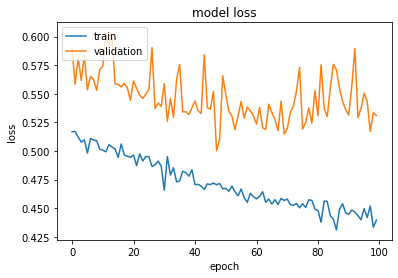

In [58]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [60]:
import math
bs = 1

predict_generator = resec_Generator1(map_df[-30:] , bs)
pred = model.predict_generator(predict_generator,  verbose = 1, pickle_safe=False)

/opt/anaconda3/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `predict_generator` call to the Keras 2 API: `predict_generator(<__main__...., verbose=1, use_multiprocessing=False)`
  """


30/30 [==============================] - 122s 4s/step


In [61]:
np.concatenate([np.round(pred), np.array(map_df.target[-30:]).reshape(-1, 1)], axis = 1)

array([[1., 1.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [1., 1.],
       [0., 1.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [1., 0.]])

In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix(map_df.target[-30:], list(np.round(pred)))

array([[10,  5],
       [ 9,  6]])

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


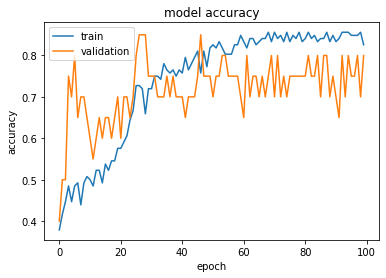

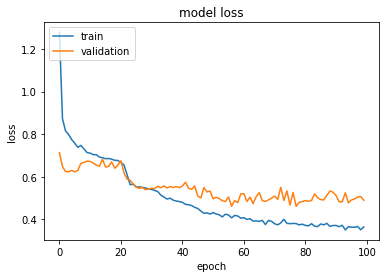

In [34]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


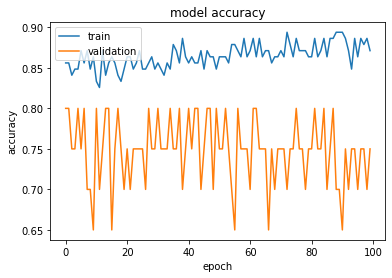

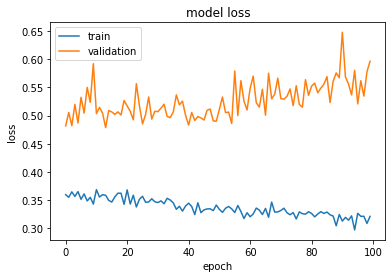

In [36]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [54]:
import math
bs = 1

predict_generator = resec_Generator1(map_df[-30:] , bs)
pred = model.predict_generator(predict_generator,  verbose = 1, pickle_safe=False)

/opt/anaconda3/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `predict_generator` call to the Keras 2 API: `predict_generator(<__main__...., verbose=1, use_multiprocessing=False)`
  """


30/30 [==============================] - 120s 4s/step


In [55]:
np.concatenate([np.round(pred), np.array(map_df.target[-30:]).reshape(-1, 1)], axis = 1)

array([[1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [0., 1.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [1., 1.],
       [0., 0.]])

In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix(map_df.target[-30:], list(np.round(pred)))

array([[11,  4],
       [ 5, 10]])

In [42]:
#epochs = 4
validation_generator = resec_Generator1(map_df[-30:],batch_size )
model.evaluate_generator(validation_generator, batch_size)

[0.09196506068110466, 1.0]